In [1]:
import pandas as pd
import stadiffuser.utils as sutils
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import stadiffuser.utils as stutils
from stadiffuser import metrics
from _utils import *
warnings.filterwarnings("ignore")
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
figure_dir = "../output/App5-STARMap_MVC/_figures"
output_dir = "../output/App5-STARMap_MVC/"
device = torch.device("cuda:0")
# create figure_dir and output_dir if not exist


method_palette = {
    'splatter':  '#8A98B8',  # Blue
    'kersplatter': '#B5BDD2',  # Lighter blue
    'zinb_spatial': "#EBAB71",  # coral
    'SRT_domain':  '#8CCF87',  # Green
    'scDesign_label': '#C0AFE2',  # Purple
    'stadiff': '#EA6666',  #coral
    "stadiff_label": "#CF4144", #lighter red
}

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 4240 edges, 1207 cells, 3.5128 neighbors per cell on average.


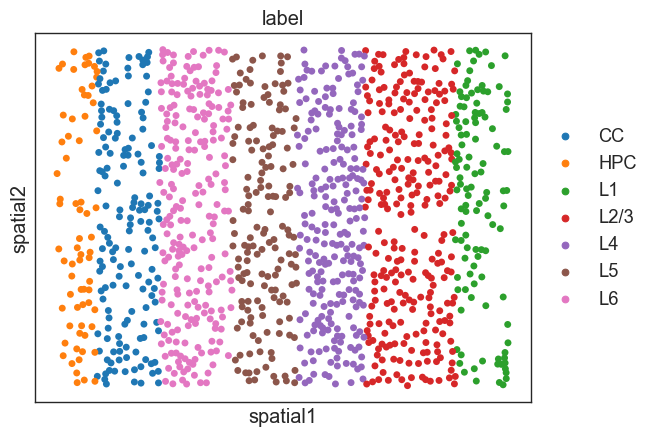

In [2]:
adata = sc.read_h5ad("E:\\Projects\\diffusion\\dataset\\STARmap_20180505_BY3_1k.h5ad")
# normalize data
adata = stutils.cal_spatial_net2D(adata, rad_cutoff=300)
# adata = sc.read_h5ad("E:\Projects\Datasets\\19310672\\scVI_kidney_object.h5ad")
sc.pl.embedding(adata, basis="spatial", color="label")
# save data to disk
adata.write_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))
sc.pp.log1p(adata)
adata.write_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))

In [3]:
spatial = adata.obsm["spatial"]
new_spatial = adata.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 150), ("division", 150)])
adata

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236


AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region'
    uns: 'label_colors', 'spatial_net', 'log1p'
    obsm: 'spatial'

In [31]:
# random mask
rng = np.random.RandomState(2024)
missing_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
for rate in missing_rate:
    mask = rng.random(size=adata.shape[0]) > rate
    adata.obs[f"random_{rate}"] = mask

In [32]:
# save data to disk
adata.write_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))

In [33]:
adata_raw = sc.read_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))
adata_raw.obs = adata.obs.copy()
# save to disk
adata_raw.write_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))

In [34]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5'
    uns: 'label_colors', 'spatial_net', 'log1p'
    obsm: 'spatial', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5'

# Benchmark with compared methods

In [2]:
output_dir = "../output/App5-STARMap_MVC/"
figure_dir = "../output/App5-STARMap_MVC/_figures"
adata = sc.read_h5ad(os.path.join(output_dir, "adata_processed.h5ad"))
adata_raw = sc.read_h5ad(os.path.join(output_dir, "adata_raw.h5ad"))
autoencoder = torch.load("{}/autoencoder_attn2.pth".format(output_dir), map_location="cuda:0")
new_spatial = adata.obsm["spatial"].copy()
new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 150), ("division", 150)])
adata.obsm["new_spatial"] = new_spatial
denoiser = torch.load(os.path.join(output_dir, "denoiser_label.pth"))
adata_real_recon = pipeline.get_recon(adata.copy(), autoencoder, device=device, apply_normalize=False)
normalizer = stutils.MinMaxNormalize(adata_real_recon.obsm["latent"], dim=0)
cond_name = "label"
num_class_embeds = len(np.unique(adata.obs[cond_name]))
class_dict = dict(zip(np.unique(adata.obs[cond_name]), range(num_class_embeds)))
autoencoder = torch.load("{}/autoencoder_attn2.pth".format(output_dir))
adata.obs["encoded_label"] = adata.obs[cond_name].map(class_dict)
class_dict

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236


{'CC': 0, 'HPC': 1, 'L1': 2, 'L2/3': 3, 'L4': 4, 'L5': 5, 'L6': 6}

label
L2/3    262
L4      230
L6      223
L5      156
CC      154
L1      113
HPC      69
Name: count, dtype: int64

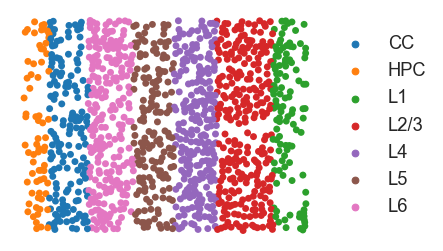

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sc.pl.embedding(adata, basis="spatial", color="label", title="", show=False, ax=ax, frameon=False)
# sc.pl.embedding(adata, basis="spatial", color="first_type", title="", show=False, ax=ax, frameon=False, legend_loc="none")
# set xlabel and ylabel, remove the title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")
adata.obs["label"].value_counts()

In [48]:
n_rep = 5
data = pipeline.prepare_dataset(adata, device=device, use_net="spatial_net")
for i in range(1, 1 + n_rep):
    stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                    ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                    labels = adata.obs["encoded_label"].to_numpy(),
                                    seed=i, normarlizer=normalizer)
    stadiff_sim.write_h5ad("{}/full_sim/stadiff_label_{}.h5ad".format(output_dir, i))

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
comp_sim_dict = dict()
for comp_method in comp_methods:
    adata_list = [sc.read_h5ad("{}/full_sim/{}_{}.h5ad".format(output_dir, comp_method, seed + 1)) for seed in range(n_rep)]
    comp_sim_dict[comp_method] = adata_list

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 comp_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "s     │
│   2 comp_sim_dict = dict()                                                                       │
│   3 for comp_method in comp_methods:                                                             │
│ ❱ 4 │   adata_list = [sc.read_h5ad("{}/full_sim/{}_{}.h5ad".format(output_dir, comp_method,      │
│   5 │   comp_sim_dict[comp_method] = adata_list                                                  │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'n_rep' is not defined

In [52]:
comp_perf_dict = compute_perf_dict(comp_sim_dict, comp_methods, autoencoder, adata_raw, adata_real_recon, device=device)

==== splatter ====
==== kersplatter ====
==== zinb_spatial ====
==== scDesign ====
==== SRT_domain ====
==== stadiff_label ====


In [53]:
# load the simulated data with label
gene_corr = dict()
for sim_name in comp_sim_dict:
    sim_adata = comp_sim_dict[sim_name][1].copy()
    sim_adata.uns["spatial_net"] = adata_real_recon.uns["spatial_net"]
    if sim_name == "stadiff_label" or sim_name == "stadiff":
        sim_adata_recon = sim_adata
    else:
        sim_adata.obs_names = adata.obs_names
        sim_adata.var_names = adata.var_names
        sim_adata.X = sim_adata.X.toarray()
        sim_adata.obsm["spatial"] = adata.obsm["spatial"]
        sim_adata_recon = pipeline.get_recon(sim_adata, autoencoder, device=device, use_net="spatial_net")
    gene_corr[sim_name] = metrics.compute_corr(sim_adata_recon, adata_real_recon, dim="gene")

## Gene violin plot

In [1]:
method_palette = {
    'splatter':  '#909AB2',  # Blue
    'kersplatter': '#B9BFCE',  # Lighter blue
    'zinb_spatial': "#DCAC80",  # coral
    'SRT_domain':  '#94C690',  # Green
    'scDesign': '#C2B5DC',  # Purple
    'stadiff': '#D37676',  #red
    "stadiff_label": "#D37676", #lighter red  “#fb9a99”
}
gene_corr_df = pd.DataFrame(gene_corr)
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
gene_corr_df = gene_corr_df[plot_methods].melt(var_name="method", value_name="correlation")
# plot boxplot for gene correlation
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.5))
# plot violin plot with edge color different and filling is blank
sns.violinplot(x="method", y="correlation", data=gene_corr_df, ax=ax,  scale='width',
               inner=None, palette={method: method_palette[method] for method in plot_methods},)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
# save to disk
plt.savefig(os.path.join(figure_dir, "gene_corr_violin.png"), dpi=300)

NameError: name 'pd' is not defined

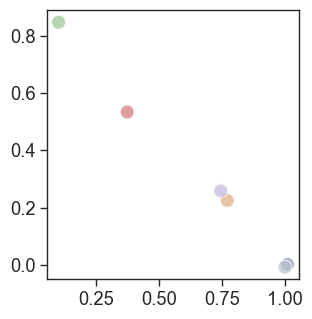

In [57]:
perf_df = extract_perf_df(comp_methods, comp_perf_dict)
plot_methods = ["splatter", "kersplatter", "zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
fig = plot_performance(perf_df, method_palette, plot_methods=plot_methods)
plt.savefig(os.path.join(figure_dir, "enhanced_gene_corr_diversity.png"), dpi=300)

## mLSI barplot

In [136]:
for method_name in comp_methods:
    print("Method: ", method_name)
    comp_perf_dict[method_name]["mLISI"] = []
    adata_sim = comp_sim_dict[method_name][0]
    if method_name == "stadiff_label" or method_name == "stadiff":
        recon_X = adata_sim.X.copy()
        latent = adata_sim.obsm["latent"].copy()
        adata_sim_recon.X = recon_X
        adata_sim_recon.obsm["latent"] = latent
    else:
        adata_sim = adata_sim.copy()
        adata_sim.X = adata_sim.X.toarray()
        adata_sim.uns["spatial_net"] = adata.uns["spatial_net"]
        adata_sim.obsm["spatial"] = adata.obsm["spatial"]
        adata_sim.obs_names = adata.obs_names
        adata_sim.var_names = adata.var_names
        adata_sim_recon = pipeline.get_recon(adata_sim, autoencoder, device=device, use_net="spatial_net")
    comp_perf_dict[method_name]["mLISI"].append(metrics.compute_paired_lisi(adata_sim_recon, adata_real_recon))

Method:  splatter
Method:  kersplatter
Method:  zinb_spatial
Method:  scDesign
Method:  SRT_domain
Method:  stadiff_label


['splatter', 'kersplatter', 'zinb_spatial', 'scDesign', 'SRT_domain', 'stadiff_label']


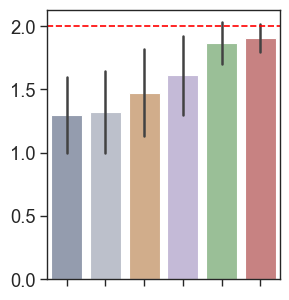

In [137]:
mLISI_df = []
print(plot_methods)
# add column to mLISI_df
for sim_name in plot_methods:
    mLISI_df.append(comp_perf_dict[sim_name]["mLISI"][0])
# convert to dataframe
mLISI_df = np.array(mLISI_df).squeeze().T
mLISI_df = pd.DataFrame(mLISI_df, columns=plot_methods)
fig, ax = plt.subplots(1, 1, figsize=(3, 3.5))
sns.barplot(data=mLISI_df, ax=ax,
            palette={method: method_palette[method] for method in plot_methods}, ci="sd")
# set a horizontal line at 2
ax.axhline(2, color="red", linestyle="--")
# set x label to empty and x axis to empty
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
# save to disk
plt.savefig(os.path.join(figure_dir, "mLISI_barplot.png"), dpi=300)

# Differential expression analysis

In [12]:
from scipy import stats
def _get_adata(ref, latent, X):
    out = ref.copy()
    out.X = X.copy()
    out.obsm["latent"] = latent.copy()
    return out
n_rep = 5
stadiff_sim_list = [sc.read_h5ad("{}/full_sim/stadiff_label_{}.h5ad".format(output_dir, i)) for i in range(1, 1 + n_rep)]

In [5]:
layer_names = adata_real_recon.obs["label"].unique().tolist()
layer_names

['L6', 'L4', 'L2/3', 'L1', 'CC', 'HPC', 'L5']

In [26]:
adata_real_recon.obs["label"].value_counts()

label
L2/3    262
L4      230
L6      223
L5      156
CC      154
L1      113
HPC      69
Name: count, dtype: int64

In [162]:
n_top_genes = 200
target_layer = "HPC"
adata_real_recon.uns["log1p"] = dict()
adata_real_recon.uns["log1p"]["base"] = np.e
sc.tl.rank_genes_groups(adata_real_recon, groupby="label", method="wilcoxon")
real_gene_list = sc.get.rank_genes_groups_df(adata_real_recon, group=target_layer, pval_cutoff=0.05).names[:n_top_genes].tolist()

In [211]:
comp_methods = ["zinb_spatial",  "scDesign", "SRT_domain", "stadiff_label"]
comp_sim_dict = dict()
for comp_method in comp_methods:
    adata_list = [sc.read_h5ad("{}/full_sim/{}_{}.h5ad".format(output_dir, comp_method, seed + 1)) for seed in range(n_rep)]
    comp_sim_dict[comp_method] = adata_list

In [229]:
method_gene_dict = dict()
for i in range(1, 1 + n_rep):
    print("Using {} simulations".format(i))
    for method_name in comp_methods:
        use_ad_list = []
        if method_name not in method_gene_dict:
            method_gene_dict[method_name] = []
        if method_name == "stadiff_label":
                for ad in comp_sim_dict[method_name][:i]:
                    use_ad_list.append(_get_adata(adata_real_recon, ad.obsm["latent"], ad.X))
        else:
            for ad in comp_sim_dict[method_name][:i]:
                ad = ad.copy()
                ad.obsm["spatial"] = adata.obsm["spatial"]
                ad.uns["spatial_net"] = adata.uns["spatial_net"]
                ad.obs_names = adata.obs_names
                ad.obs = adata.obs.copy()
                ad.var_names = adata.var_names
                ad = pipeline.get_recon(ad, autoencoder, device=device, use_net="spatial_net")
                use_ad_list.append(ad)
        print("Method: ", method_name, len(use_ad_list))
        ad_temp = sc.AnnData.concatenate(*use_ad_list)
        sc.tl.rank_genes_groups(ad_temp, groupby="label", method="wilcoxon")
        method_gene_dict[method_name].append(sc.get.rank_genes_groups_df(ad_temp, group=target_layer, pval_cutoff=0.05).names[:n_top_genes].tolist())

Using 1 simulations
Method:  zinb_spatial 1
Method:  scDesign 1
Method:  SRT_domain 1
Method:  stadiff_label 1
Using 2 simulations
Method:  zinb_spatial 2
Method:  scDesign 2
Method:  SRT_domain 2
Method:  stadiff_label 2
Using 3 simulations
Method:  zinb_spatial 3
Method:  scDesign 3
Method:  SRT_domain 3
Method:  stadiff_label 3
Using 4 simulations
Method:  zinb_spatial 4
Method:  scDesign 4
Method:  SRT_domain 4
Method:  stadiff_label 4
Using 5 simulations
Method:  zinb_spatial 5
Method:  scDesign 5
Method:  SRT_domain 5
Method:  stadiff_label 5


In [392]:
# compute the overlap between the consecutive simulations
consecutive_overlap = dict()
for method in method_gene_dict:
    consecutive_overlap[method] = []
    for i in range(n_rep - 1):
        gene_list1 = set(method_gene_dict[method][i])
        gene_list2 = set(method_gene_dict[method][i + 1])
        overlap = len(gene_list1.intersection(gene_list2))
        consecutive_overlap[method].append(overlap)
consecutive_overlap_df = pd.DataFrame(consecutive_overlap)
# melt the dataframe
consecutive_overlap_df = consecutive_overlap_df.melt(var_name="method", value_name="overlap", ignore_index=False)
consecutive_overlap_df["rep"] = consecutive_overlap_df.index

In [396]:
consecutive_overlap_df.index

Index([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], dtype='int64')

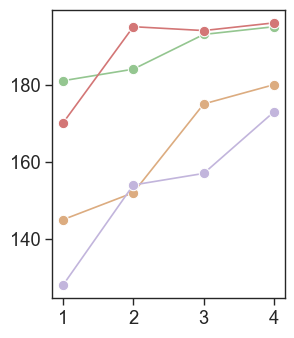

In [410]:
plt.rcParams['lines.markersize'] = 7.5
fig, ax = plt.subplots(1, 1, figsize=(3, 3.75))
sns.lineplot(data=consecutive_overlap_df, ax=ax,
             x="rep", y="overlap", hue="method",
             palette={method: method_palette[method] for method in comp_methods}, marker="o",
             legend=None,
             linestyle="-")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([rep for rep in range(n_rep-1)])
ax.set_xticklabels([rep + 1 for rep in range(n_rep-1)])
# save to disk
plt.savefig(os.path.join(figure_dir, "consecutive_overlap_lineplot.png"), dpi=300)

In [294]:
marker_gene_df = pd.read_csv(os.path.join(output_dir, "HPC_marker.csv"))
hpc_maker_genes = marker_gene_df["Cell marker"].tolist()
real_overlap = dict()
marker_overlap = dict()
for method in method_gene_dict:
    real_overlap[method] = []
    marker_overlap[method] = []
    for gene_list in method_gene_dict[method]:
        overlap = len(set(real_gene_list).intersection(set(gene_list)))
        real_overlap[method].append(overlap)
        overlap = len(set(hpc_maker_genes).intersection(set(gene_list)))
        marker_overlap[method].append(overlap)
real_overlap

{'zinb_spatial': [68, 71, 60, 60, 62],
 'scDesign': [91, 96, 101, 107, 113],
 'SRT_domain': [117, 121, 122, 123, 125],
 'stadiff_label': [150, 159, 158, 160, 158]}

In [382]:
real_overlap_df = pd.DataFrame(real_overlap)
real_overlap_df
# melt with row index
real_overlap_df = real_overlap_df.melt(var_name="method", value_name="overlap", ignore_index=False)
real_overlap_df["rep"] = real_overlap_df.index


,method,overlap,rep
0,zinb_spatial,68,0
1,zinb_spatial,71,1
2,zinb_spatial,60,2
3,zinb_spatial,60,3
4,zinb_spatial,62,4
0,scDesign,91,0
1,scDesign,96,1
2,scDesign,101,2
3,scDesign,107,3
4,scDesign,113,4


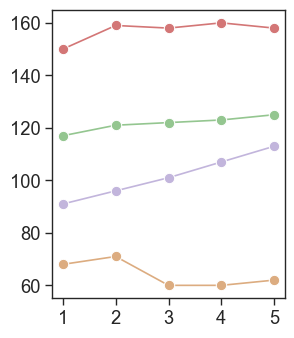

In [411]:
plt.rcParams['lines.markersize'] = 7.5
fig, ax = plt.subplots(1, 1, figsize=(3, 3.75))
sns.lineplot(data=real_overlap_df, ax=ax,
             x="rep", y="overlap", hue="method",
             palette={method: method_palette[method] for method in comp_methods}, marker="o",
             legend=None,
             linestyle="-")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([rep for rep in range(n_rep)])
ax.set_xticklabels([rep + 1 for rep in range(n_rep)])
# save to disk
plt.savefig(os.path.join(figure_dir, "real_overlap_lineplot.png"), dpi=300)

In [339]:
diff_df_dict = dict()
for method_name in comp_methods:
    go_df_list = []
    for gene_list in method_gene_dict[method_name]:
        method_go = sc.queries.enrich(list(gene_list), org="mmusculus")
        method_go["-log10(p)"] = -np.log10(method_go["p_value"])
        recon_go = sc.queries.enrich(list(real_gene_list), org="mmusculus")
        recon_go["-log10(p)"] = -np.log10(recon_go["p_value"])
        # join the two dataframe by name
        go_df = pd.merge(method_go[["name", "-log10(p)"]], recon_go[["name", "-log10(p)"]], on="name",
                         suffixes=("_{}".format(method_name), "_real_recon"), how="outer")
        # replace the nan with 0
        go_df = go_df.fillna(0)
        go_df["diff"] = go_df["-log10(p)_{}".format(method_name)] - go_df["-log10(p)_real_recon"]
        go_df_list.append(go_df)
    diff_df = []
    for ind, go_df in enumerate(go_df_list):
        tuples = [(method_name, ind + 1, go_df["diff"][i]) for i in range(go_df.shape[0])]
        diff_df.extend(tuples)
    diff_df = pd.DataFrame(diff_df, columns=["method", "rep", "diff"])
    diff_df_dict[method_name] = diff_df

In [345]:
diff_df_all = pd.concat([diff_df_dict[method_name] for method_name in comp_methods], axis=0)

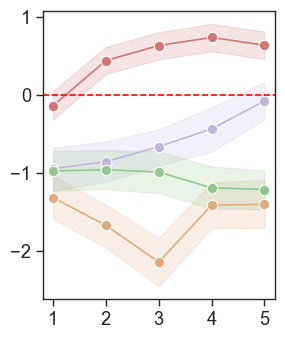

In [412]:
plt.rcParams['lines.markersize'] = 7.5
fig, ax = plt.subplots(1, 1, figsize=(3, 3.75))
# set marker size to 10
sns.lineplot(data=diff_df_all, x="rep", y="diff", hue="method",
             marker="o", palette={method: method_palette[method] for method in comp_methods}, ax=ax, legend=None)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([rep + 1 for rep in range(n_rep)])
# add a horizontal line at 0
ax.axhline(0, color="red", linestyle="--")
# save to disk
plt.savefig(os.path.join(figure_dir, "GO_diff_lineplot.png"), dpi=300)

0 -0.1374192377027478 p-value: 8.79e-01
1 0.44020657018325793 p-value: 4.19e-07
2 0.6323299504210242 p-value: 4.13e-12
3 0.7357828652128485 p-value: 5.40e-15
4 0.6368858996631332 p-value: 6.64e-12


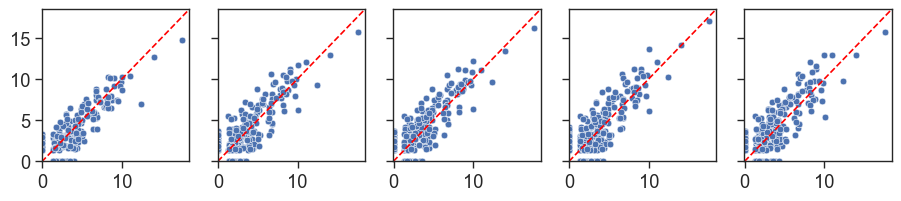

In [291]:
# plot scatter
fig, ax = plt.subplots(1, len(method_gene_dict[method_name]), figsize=(9.25, 2.25), sharex=True, sharey=True)
for i, go_df in enumerate(go_df_list):
    # Null hypothesis: recon > method
    # perform one-side t-test between the two groups
    pval = stats.wilcoxon(go_df["diff"], alternative="greater").pvalue
    # pval using sci notations keep two decimals
    print(i, go_df["diff"].mean(), "p-value: {:.2e}".format(pval))
    sns.scatterplot(data=go_df, y="-log10(p)_{}".format(method_name), x="-log10(p)_real_recon", ax=ax[i])
    # add diagonal line
    y_lim = ax[i].get_xlim()
    ax[i].set_ylim([-0.05, y_lim[1]])
    ax[i].set_xlim([-0.05, y_lim[1]])
    ax[i].plot(y_lim, y_lim, color="red", linestyle="--")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
plt.tight_layout()
# save to disk
plt.savefig(os.path.join(figure_dir, "{}_GO_scatter.png".format(method_name)), dpi=300)

In [413]:
stadiff_gene_list = method_gene_dict["stadiff_label"]
stadiff_unique = set(stadiff_gene_list[-1]) - set(real_gene_list)


In [415]:
stadiff_unique.intersection(set(hpc_maker_genes))

{'Gsn', 'Kit'}

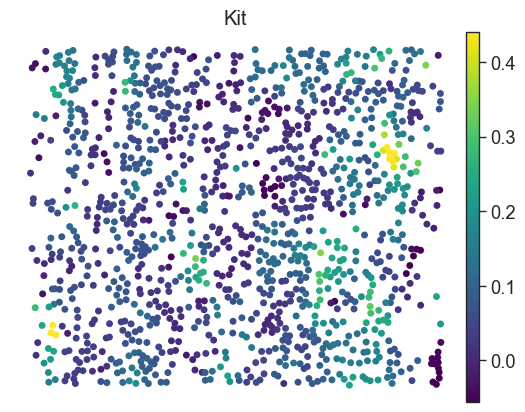

In [424]:
sc.pl.embedding(adata_real_recon, basis="spatial", color="Kit", cmap="viridis", frameon=False, vmax="p99.5", vmin="p1")

## Compare STADiffuser with 1 and 5 simulations with the real data

150 159
170


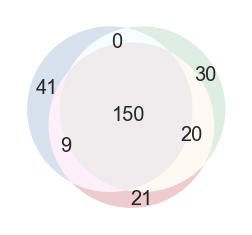

In [450]:
from matplotlib_venn import venn3
gene_list1 = method_gene_dict["stadiff_label"][0]
gene_list2 = method_gene_dict["stadiff_label"][1]
overlap1 = len(set(real_gene_list).intersection(set(gene_list1)))
overlap2 = len(set(real_gene_list).intersection(set(gene_list2)))
overlap12 = len(set(gene_list1).intersection(set(gene_list2)))
print(overlap1, overlap2)
print(overlap12)
#print veen diagram
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
venn3([set(real_gene_list), set(gene_list1), set(gene_list2)], set_labels=None, ax=ax,
      set_colors = ["#9FB4D5", "#AED6B7", "#D58183"])

In [488]:
filter_source = ["GO:CC", "GO:MF", "GO:BP"]
go_stadiff_1 = sc.queries.enrich(list(gene_list1), org="mmusculus")
go_stadiff_1["-log10(p)"] = -np.log10(go_stadiff_1["p_value"])
go_stadiff_5 = sc.queries.enrich(list(gene_list2), org="mmusculus")
go_stadiff_5["-log10(p)"] = -np.log10(go_stadiff_5["p_value"])
go_real = sc.queries.enrich(list(real_gene_list), org="mmusculus")
go_real["-log10(p)"] = -np.log10(go_real["p_value"])
go_stadiff_1["diff"] = go_stadiff_1["-log10(p)"] - go_real["-log10(p)"]
go_stadiff_5["diff"] = go_stadiff_5["-log10(p)"] - go_real["-log10(p)"]
go_real["diff"] = 0
go_real["method"] = "real"
go_stadiff_1["method"] = "stadiff_1"
go_stadiff_5["method"] = "stadiff_5"
# filter the go terms
go_real = go_real[go_real["source"].isin(filter_source)]
go_stadiff_1 = go_stadiff_1[go_stadiff_1["source"].isin(filter_source)]
go_stadiff_5 = go_stadiff_5[go_stadiff_5["source"].isin(filter_source)]
go_df = pd.merge(go_real[["name", "-log10(p)"]], go_stadiff_1[["name", "-log10(p)"]], on="name",
                 suffixes=("_real", "_stadiff_1"), how="outer")
go_df = pd.merge(go_df, go_stadiff_5[["name", "-log10(p)"]], on="name", suffixes=("", "_stadiff_5"), how="outer")
go_df.columns = ["name", "real", "stadiff_1", "stadiff_5"]

In [510]:
go_df[~go_df["real"].isna() & go_df["stadiff_5"].isna()].sort_values("real", ascending=False)

,name,real,stadiff_1,stadiff_5
280,secretion,3.505283,NaN,NaN
35,calcium ion binding,3.270358,3.366834,NaN
238,regulation of epithelial cell migration,2.721751,1.888793,NaN
4,ERK1 and ERK2 cascade,2.604581,NaN,NaN
97,export from cell,2.496224,NaN,NaN
194,perineuronal net,2.198837,NaN,NaN
195,perinuclear region of cytoplasm,2.144515,NaN,NaN
146,main axon,2.130712,NaN,NaN
196,perisynaptic extracellular matrix,2.025005,NaN,NaN
254,regulation of secretion,1.969395,NaN,NaN


In [495]:
stadiff_unique_names = go_df[go_df["real"].isna() & ~go_df["stadiff_5"].isna()].sort_values("stadiff_5", ascending=False).head(10).name
real_unique_names = go_df[~go_df["real"].isna() & go_df["stadiff_5"].isna()].sort_values("real", ascending=False).head(10).name
common_names = go_df[~go_df["real"].isna() & ~go_df["stadiff_5"].isna()].sort_values("real", ascending=False).head(15).name

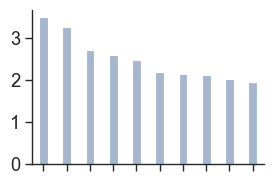

In [549]:
# real and stadiff_5 a
sns.set_theme("paper", "ticks", font_scale=1.5)
go_df_sub = go_df[go_df["name"].isin(real_unique_names)]
# sort the dataframe
go_df_sub = go_df_sub.sort_values("real", ascending=False)
# plot
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.barplot(data=go_df_sub, x="name", y="real", ax=ax, color="#9FB4D5", width=0.375)
# rotate the x-axis label
sns.despine()
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(os.path.join(figure_dir, "GO_real_unique.png"), dpi=300)

In [554]:
print("Real unique")
for k in real_unique_names.tolist():
    print(k)
print("=============STADiff unique")
for k in stadiff_unique_names.tolist():
    print(k)
print("=============Common")
for k in common_names.tolist():
    print(k)

Real unique
secretion
calcium ion binding
regulation of epithelial cell migration
ERK1 and ERK2 cascade
export from cell
perineuronal net
perinuclear region of cytoplasm
main axon
perisynaptic extracellular matrix
regulation of secretion
=============STADiff unique
glial cell fate commitment
oligodendrocyte differentiation
regulation of signal transduction
regulation of behavior
regulation of intracellular signal transduction
neuron development
cellular lipid metabolic process
negative regulation of protein metabolic process
fatty acid biosynthetic process
negative regulation of developmental process
=============Common
system development
multicellular organism development
extracellular region
cell body
cell periphery
nervous system development
anatomical structure development
cell adhesion
response to endogenous stimulus
regulation of multicellular organismal process
gliogenesis
neuronal cell body
animal organ development
behavior
membrane


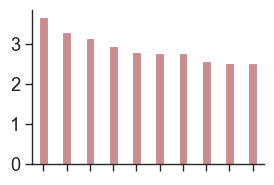

In [548]:
go_df_sub = go_df[go_df["name"].isin(stadiff_unique_names)]
go_df_sub = go_df_sub.sort_values("stadiff_5", ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.barplot(data=go_df_sub, x="name", y="stadiff_5", ax=ax, color="#D58183", width=0.375)
sns.despine()
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
plt.savefig(os.path.join(figure_dir, "GO_stadiff_unique.png"), dpi=300)

['system development',
 'multicellular organism development',
 'extracellular region',
 'cell body',
 'cell periphery',
 'nervous system development',
 'anatomical structure development',
 'cell adhesion',
 'response to endogenous stimulus',
 'regulation of multicellular organismal process',
 'gliogenesis',
 'neuronal cell body',
 'animal organ development',
 'behavior',
 'membrane']

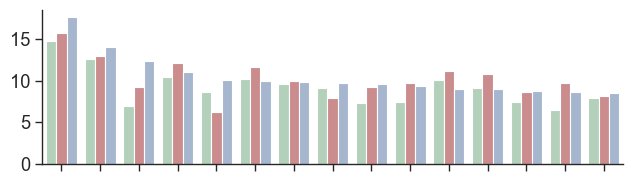

In [547]:
go_df_sub = go_df[go_df["name"].isin(common_names)]
go_df_sub = go_df_sub.sort_values("real", ascending=False)
# pot barplot with common names as x and real, stadiff_1 and stadiff_5 as y
# metlt
go_df_sub = go_df_sub.melt(id_vars="name", value_vars=["real", "stadiff_1", "stadiff_5"], var_name="method", value_name="-log10(p)")
fig, ax = plt.subplots(1, 1, figsize=(7.5, 2))
sns.barplot(data=go_df_sub, x="name", y="-log10(p)", hue="method", ax=ax,
            hue_order=["stadiff_1", "stadiff_5", "real"],
            palette={"real": "#9FB4D5", "stadiff_1": "#AED6B7", "stadiff_5": "#D58183"},legend=None)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine()
plt.savefig(os.path.join(figure_dir, "GO_common.png"), dpi=300)
common_names.tolist()

#  Super-resolution
not working. The number of spots is too small (1020)

In [144]:
from stadiffuser.utils import mask_region
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
n_rep = 5
for missing_rate in missing_rates:
    print("Missing rate: ", missing_rate)
    mask = "random_{}".format(missing_rate)
    denoiser_masked = torch.load("{}/{}/denoiser_label.pth".format(output_dir, mask), map_location="cuda:0")
    autoencoder_masked = torch.load("{}/{}/autoencoder_attn2.pth".format(output_dir, mask), map_location="cuda:0")
    new_spatial = adata.obsm["spatial"].copy()
    new_spatial = stutils.quantize_coordination(new_spatial, methods=[("division", 150), ("division", 150)])
    adata.obsm["new_spatial"] = new_spatial
    adata_masked = mask_region(adata, mask)
    adata_masked_recon = pipeline.get_recon(adata_masked, autoencoder_masked, device=device, use_net="spatial_net",
                                   apply_normalize=False)
    normalizer = stutils.MinMaxNormalize(adata_masked_recon.obsm["latent"], dim=0)
    data = pipeline.prepare_dataset(adata, device=device, use_net="spatial_net")
    # simulate
    for i in range(1, n_rep+1):
        adata_sim = pipeline.simulate(denoiser_masked, autoencoder_masked, device=device, use_net="spatial_net",
                                      ref_data=adata, spatial_coord=adata.obsm["new_spatial"],
                                      labels = adata.obs["encoded_label"].to_numpy(),
                                      seed=i, normarlizer=normalizer)
        adata_sim.write_h5ad("{}/{}/stadiff_{}.h5ad".format(output_dir, mask, i))

Missing rate:  0.1
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236
--------------------
Remove 87 nodes and 562 edges from the original data
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Missing rate:  0.2
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236
--------------------
Remove 223 nodes and 1404 edges from the original data
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Missing rate:  0.3
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236
--------------------
Remove 355 nodes and 2146 edges from the original data
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Missing rate:  0.4
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236
--------------------
Remove 487 nodes and 2672 edges from the original data
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Missing rate:  0.5
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941087
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502236
--------------------
Remove 602 nodes and 3100 edges from the original data
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [176]:
stadiff_sim_list = []
srt_sim_list = []
srt_sim_recon_list = []
output_root = "../output/App5-STARMap_MVC"
cond_name = "label"
for missing_rate in missing_rates:
    print("Missing rate: ", missing_rate)
    mask = "random_{}".format(missing_rate)
    autoencoder_masked = torch.load("{}/{}/autoencoder_attn2.pth".format(output_root, mask), map_location="cuda:0").to(device)
    stadiff_sim = sc.read_h5ad("{}/{}/stadiff_2.h5ad".format(output_root, mask))
    srt_sim = sc.read_h5ad("{}/{}/SRTSim_fill_inplace2.h5ad".format(output_root, mask))
    # add spatial information
    srt_sim.obsm["spatial"] = adata.obsm["spatial"]
    srt_sim.uns["spatial_net"] = adata.uns["spatial_net"]
    srt_sim.obs_names = adata.obs_names
    srt_sim.obs[cond_name] = adata.obs[cond_name]
    srt_sim_recon = pipeline.get_recon(srt_sim, autoencoder_masked, device=device, use_net="spatial_net",
                               apply_normalize=True)
    stadiff_sim_list.append(stadiff_sim)
    srt_sim_list.append(srt_sim)
    srt_sim_recon_list.append(srt_sim_recon)

Missing rate:  0.1
Missing rate:  0.2
Missing rate:  0.3
Missing rate:  0.4
Missing rate:  0.5


In [153]:
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon, min_dist=0.5)

In [156]:
# compute gene correlation
for ind in range(len(stadiff_sim_list)):
    sc.pp.neighbors(stadiff_sim_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(stadiff_sim_list[ind], min_dist=0.5)
    sc.pp.neighbors(srt_sim_recon_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(srt_sim_recon_list[ind], min_dist=0.5)
stadiff_corr_list = [metrics.compute_corr(stadiff_sim, adata_real_recon, dim="gene") for stadiff_sim in stadiff_sim_list]
srt_corr_list = [metrics.compute_corr(srt_sim_recon, adata_real_recon, dim="gene") for srt_sim_recon in srt_sim_recon_list]
srt_lsi_list = [metrics.compute_paired_lisi(srt_sim_recon, adata_real_recon, use_rep="X_umap") for srt_sim_recon in srt_sim_recon_list]
stadiff_lsi_list = [metrics.compute_paired_lisi(_get_adata(srt_sim_recon_list[0], stadiff_sim.obsm["latent"], stadiff_sim.X),
                                                adata_real_recon, use_rep="X_umap") for stadiff_sim in stadiff_sim_list]

In [ ]:
# compute gene correlation
for ind in range(len(stadiff_sim_list)):
    sc.pp.neighbors(stadiff_sim_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(stadiff_sim_list[ind], min_dist=0.5)
    sc.pp.neighbors(srt_sim_recon_list[ind], use_rep="latent", n_neighbors=30)
    sc.tl.umap(srt_sim_recon_list[ind], min_dist=0.5)
stadiff_corr_list = [metrics.compute_corr(stadiff_sim, adata_real_recon, dim="gene") for stadiff_sim in stadiff_sim_list]
srt_corr_list = [metrics.compute_corr(srt_sim_recon, adata_real_recon, dim="gene") for srt_sim_recon in srt_sim_recon_list]
stadiff_lsi_list = [metrics.compute_paired_lisi(stadiff_sim, adata_real_recon, use_rep="X_umap") for stadiff_sim in stadiff_sim_list]
srt_lsi_list = [metrics.compute_paired_lisi(srt_sim_recon, adata_real_recon, use_rep="X_umap") for srt_sim_recon in srt_sim_recon_list]

In [177]:
stadiff_corr_list = [metrics.compute_corr(stadiff_sim, adata_real_recon, dim="gene") for stadiff_sim in stadiff_sim_list]
srt_corr_list = [metrics.compute_corr(srt_sim_recon, adata_real_recon, dim="gene") for srt_sim_recon in srt_sim_recon_list]
gene_corr_df = pd.DataFrame(np.array(stadiff_corr_list).T)
gene_corr_df = gene_corr_df.set_index(adata.var_names)
# 3000 genes with respect to the seven missing rates
gene_corr_df = gene_corr_df.set_index(adata.var_names)
# set column names
gene_corr_df.columns = missing_rates
gene_corr_df["method"] = "STADiffuser"
# append srt_corr_list
srt_corr_df = pd.DataFrame(np.array(srt_corr_list).T)
srt_corr_df = srt_corr_df.set_index(adata.var_names)
srt_corr_df.columns = missing_rates
srt_corr_df["method"] = "SRTSim"
# append to gene_corr_df
gene_corr_df = pd.concat([gene_corr_df, srt_corr_df], axis=0)
# metlt the dataframe
gene_corr_df = gene_corr_df.melt(id_vars=["method"], var_name="missing_rate", value_name="gene_corr", ignore_index=False)

In [173]:
srt_lsi_df = pd.DataFrame(np.concatenate(stadiff_lsi_list, axis=1))
srt_lsi_df.columns = missing_rates
srt_lsi_df["method"] = "SRTSim"
stadiff_lsi_df = pd.DataFrame(np.concatenate(srt_lsi_list, axis=1))
stadiff_lsi_df.columns = missing_rates
stadiff_lsi_df["method"] = "STADiffuser"
# append to gene_corr_df
lsi_df = pd.concat([srt_lsi_df, stadiff_lsi_df], axis=0)
# del srt_lsi_df, stadiff_lsi_df
# metlt the dataframe keep gene name as the index
lsi_df = lsi_df.melt(id_vars=["method"], var_name="missing_rate", value_name="lsi")

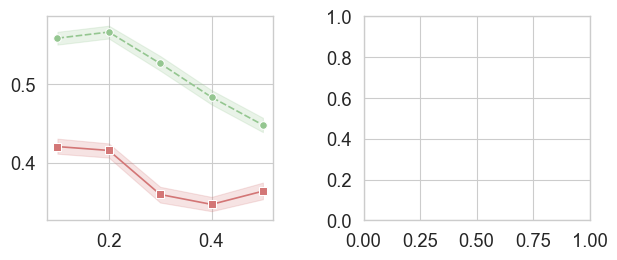

In [178]:
plot_palette = {"STADiffuser": method_palette["stadiff"],
                "SRTSim": method_palette["SRT_domain"]}
fig, axes = plt.subplots(1, 2, figsize=(7, 2.65))
#plot the gene correlation lineplot
ax = axes[0]
sns.lineplot(data=gene_corr_df, x="missing_rate", y="gene_corr", hue="method", ax=ax, style_order=["STADiffuser", "SRTSim"],
             palette=plot_palette, markers=["s", "o"], style="method", ci=95, markersize=5.5)
# remove legend
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
# plot mLISI lineplot
# ax = axes[1]
# sns.lineplot(data=lsi_df, x="missing_rate", y="lsi", hue="method", ax=ax, style_order=["STADiffuser", "SRTSim"],
#              palette=plot_palette, markers=["s", "o"], style="method", ci=95, markersize=5.5)
# # remove legend
# ax.legend().remove()
# ax.set_xlabel("")
# ax.set_ylabel("")
plt.subplots_adjust(wspace=0.4)

<Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>

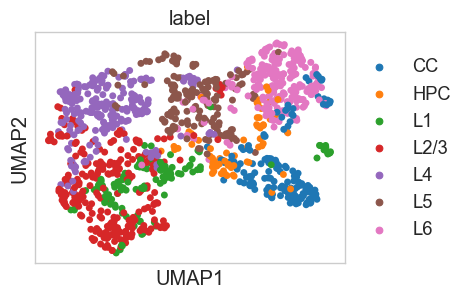

In [182]:
# plot umap of adata_real_recon
sc.pp.neighbors(adata_real_recon, use_rep="latent", n_neighbors=30)
sc.tl.umap(adata_real_recon, min_dist=0.5)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sc.pl.umap(adata_real_recon, color="label", ax=ax, show=False)

In [195]:
"Cux2" in adata.var_names

True

[<Axes: xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'label'}, xlabel='spatial1', ylabel='spatial2'>]

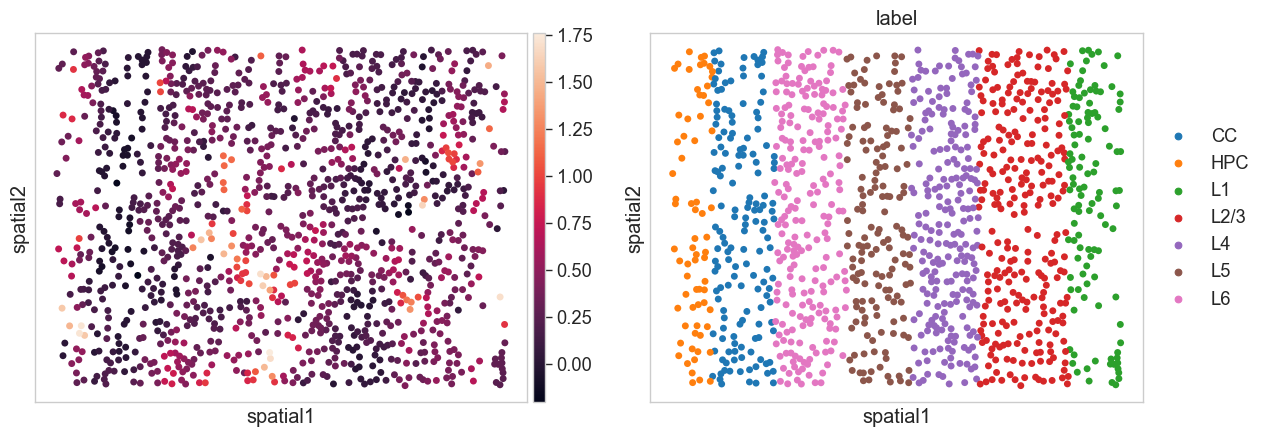

In [198]:
#
sc.pl.embedding(adata_real_recon, basis="spatial", color=["Gad1", "label"], title="", show=False)

In [199]:
adata_real_recon.obs["label"].value_counts()

label
L2/3    262
L4      230
L6      223
L5      156
CC      154
L1      113
HPC      69
Name: count, dtype: int64

In [208]:
# compute the differential expression between L5 and L6
adata_real_recon.uns["log1p"] = dict()
adata_real_recon.uns["log1p"]["base"] = np.e
# retain layers
retain_layers = ["CC", "HPC"]
adata_sub = adata_real_recon[adata.obs["label"].isin(["L5", "L6"])].copy()
sc.tl.rank_genes_groups(adata_sub, groupby="label", method="wilcoxon", n_genes=1000)
adata_sub

AnnData object with n_obs × n_vars = 379 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5'
    uns: 'label_colors', 'log1p', 'spatial_net', 'edge_list', 'neighbors', 'umap', 'rank_genes_groups'
    obsm: 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'spatial', 'new_spatial', 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [209]:
# get the top 10 genes
sc.get.rank_genes_groups_df(adata_real_recon, group="HPC",  pval_cutoff=0.05)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Mmd2,9.481406,0.725434,2.508792e-21,8.311207e-20
1,Sst,9.157024,2.075730,5.334797e-20,1.295594e-18
2,Gfap,9.034314,1.068865,1.650338e-19,3.506968e-18
3,Ednrb,8.481585,0.464797,2.221467e-17,3.540463e-16
4,Ptprz1,8.263196,0.634148,1.418225e-16,1.903408e-15
...,...,...,...,...,...
693,Mef2c,-9.650355,-1.587218,4.898587e-22,1.998624e-20
694,Pcdhga7,-9.708331,-0.966864,2.778491e-22,1.180859e-20
695,Gfra2,-9.709754,-1.006063,2.739981e-22,1.180859e-20
696,Arc,-9.752436,-1.845034,1.800947e-22,8.349844e-21
